In [1]:
import os
import re
import h5py
import ROOT

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

Welcome to JupyROOT 6.20/08


0

In [2]:
def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

# Basic Information

In [3]:
def get_number_of_constituents(tree):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    n_consti = [[],[]]

    for event_id, event in tqdm(enumerate(tree)):

        if event.Jet_size < 2:
            continue

        if event.Jet[1].PT < 750:
            continue

        if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
            continue

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)

        if mjj < 4300 or mjj > 5900:
            continue

        # Get number of constituents
        constituents = [consti for consti in event.Jet[0].Constituents if consti != 0]
        n_consti[0].append(len(constituents))

        constituents = [consti for consti in event.Jet[1].Constituents if consti != 0]
        n_consti[1].append(len(constituents))

    return n_consti

In [5]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

n_consti_s = get_number_of_constituents(tree_s)

10000it [00:21, 473.35it/s]


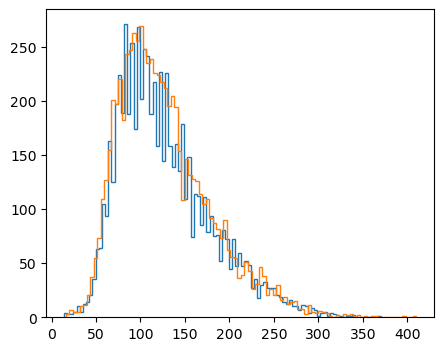

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))
ax.hist(n_consti_s[0], bins=100, histtype='step')
ax.hist(n_consti_s[1], bins=100, histtype='step')

plt.show()

# From .root to .h5

In [7]:
# HDF5
def create_dataset(f, nevent, MAX_JETS):

    f.create_dataset('J1/MASK', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='|b1')
    f.create_dataset('J1/pt', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J1/eta', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J1/phi', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')

    f.create_dataset('J2/MASK', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='|b1')
    f.create_dataset('J2/pt', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J2/eta', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J2/phi', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')

    f.create_dataset('EVENT/Mjj', (nevent,), maxshape=(None,), dtype='<f4')
    f.create_dataset('EVENT/signal', (nevent,), maxshape=(None,), dtype='<i8')

def write_dataset(file, index, data: dict):

    for key, value in data.items():
        file[key][index] = value

def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

def resize_h5(file_path, nevent):

    with h5py.File(file_path,'r+') as f:
        keys = get_dataset_keys(f)
        for key in keys:
            shape = list(f[key].shape)
            shape[0] = nevent
            f[key].resize(shape)
    print(f'{file_path} resize to {nevent}')

In [8]:
def get_pt_eta_phi(constituents):
    pts, etas, phis  = [], [], []
    
    for consti in constituents:
        try:
            pts.append(consti.PT)
            etas.append(consti.Eta)
            phis.append(consti.Phi)

        except:
            pts.append(consti.ET)
            etas.append(consti.Eta)
            phis.append(consti.Phi)
            
    pts = np.array(pts)
    etas = np.array(etas)
    phis = np.array(phis)

    return pts, etas, phis

def from_root_to_h5(tree, output_path, nevent, signal):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0
    # 4. 4300 < Mjj < 5900 GeV

    MAX_JETS = 300

    event_index = 0
    with h5py.File(output_path, 'w') as f_out:

        create_dataset(f_out, nevent, MAX_JETS)

        for event_id, event in tqdm(enumerate(tree)):

            if event.Jet_size < 2:
                continue

            if event.Jet[1].PT < 750:
                continue

            if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
                continue

            jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
            mjj = Mjets(*jets)

            if mjj < 4300 or mjj > 5900:
                continue
            
            # get jet constituents
            constituents = [consti for consti in event.Jet[0].Constituents if consti != 0]
            n_consti_1 = len(constituents)
            PT1, Eta1, Phi1 = get_pt_eta_phi(constituents)

            constituents = [consti for consti in event.Jet[1].Constituents if consti != 0]
            n_consti_2 = len(constituents)
            PT2, Eta2, Phi2 = get_pt_eta_phi(constituents)

            if n_consti_1 < 5 or n_consti_2 < 5:
                continue
             
            # 準備寫入資料
            data_dict = {
                'J1/MASK': np.arange(MAX_JETS)<n_consti_1,
                'J1/pt': PT1[:MAX_JETS] if n_consti_1>MAX_JETS else np.pad(PT1, (0,MAX_JETS-n_consti_1)),
                'J1/eta': Eta1[:MAX_JETS] if n_consti_1>MAX_JETS else np.pad(Eta1, (0,MAX_JETS-n_consti_1)),
                'J1/phi': Phi1[:MAX_JETS] if n_consti_1>MAX_JETS else np.pad(Phi1, (0,MAX_JETS-n_consti_1)),

                'J2/MASK': np.arange(MAX_JETS)<n_consti_2,
                'J2/pt': PT2[:MAX_JETS] if n_consti_2>MAX_JETS else np.pad(PT2, (0,MAX_JETS-n_consti_2)),
                'J2/eta': Eta2[:MAX_JETS] if n_consti_2>MAX_JETS else np.pad(Eta2, (0,MAX_JETS-n_consti_2)),
                'J2/phi': Phi2[:MAX_JETS] if n_consti_2>MAX_JETS else np.pad(Phi2, (0,MAX_JETS-n_consti_2)),
            
                'EVENT/Mjj': mjj,
                'EVENT/signal': signal,
            }

            write_dataset(f_out, event_index, data_dict)
            event_index += 1

    resize_h5(output_path, event_index)

In [14]:
root_path = '../../Software/pythia8307/HVmodel/test_100k.root'
output_path = './HVmodel/data/DA/signal.h5'
sample_type = 1

cmd = f'python from_root_to_h5.py {root_path} {output_path} {sample_type}'
print(cmd)

root_path = '../../Software/pythia8307/HVmodel/test_100k-2.root'
output_path = './HVmodel/data/DA/signal-test.h5'
sample_type = 1

cmd = f'python from_root_to_h5.py {root_path} {output_path} {sample_type}'
print(cmd)

root_path = './ppjj/Events/run_03/tag_1_delphes_events.root'
output_path = './HVmodel/data/DA/background.h5'
sample_type = 0

cmd = f'python from_root_to_h5.py {root_path} {output_path} {sample_type}'
print(cmd)

root_path = './ppjj/Events/run_04/tag_1_delphes_events.root'
output_path = './HVmodel/data/DA/background-test.h5'
sample_type = 0

cmd = f'python from_root_to_h5.py {root_path} {output_path} {sample_type}'
print(cmd)

python from_root_to_h5.py ../../Software/pythia8307/HVmodel/test_100k.root ./HVmodel/data/DA/signal.h5 1
python from_root_to_h5.py ../../Software/pythia8307/HVmodel/test_100k-2.root ./HVmodel/data/DA/signal-test.h5 1
python from_root_to_h5.py ./ppjj/Events/run_03/tag_1_delphes_events.root ./HVmodel/data/DA/background.h5 0
python from_root_to_h5.py ./ppjj/Events/run_04/tag_1_delphes_events.root ./HVmodel/data/DA/background-test.h5 0


# Make mix sample

## Pre-selection 

In [7]:
def HV_selection(tree):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0

    n_event_count = 0
    n_jet_count = 0
    jet_pt_count = 0
    jet_eta_count = 0
    mjjs = []

    pt = [[],[]]

    for event_id, event in tqdm(enumerate(tree)):
        n_event_count += 1

        if event.Jet_size < 2:
            continue
        n_jet_count += 1

        pt[0].append(event.Jet[0].PT)
        pt[1].append(event.Jet[1].PT)
        if event.Jet[1].PT < 750:
            continue
        jet_pt_count += 1

        if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
            continue
        jet_eta_count += 1

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)
        mjjs.append(mjj)

        if mjj < 4300 or mjj > 5900:
            continue


    mjjs = np.array(mjjs)
    SR_count = ((mjjs > 4700) & (mjjs < 5500)).sum()
    SB_count = (((mjjs > 4300) & (mjjs < 4700)) | ((mjjs > 5500) & (mjjs < 5900))).sum()

    cutflow_number = {
        'Total': n_event_count,
        'n jet cut': n_jet_count,
        'jet pt cut': jet_pt_count,
        'jet eta cut': jet_eta_count,
        'Signal region': SR_count,
        'Sideband region': SB_count,
    }

    results = {
        'mjj': mjjs,
        'pt': np.array(pt),
        'cutflow_number': cutflow_number,
    }

    return results

In [8]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

results_s = HV_selection(tree_s)

100000it [02:41, 620.00it/s]


In [9]:
root_file = './ppjj/Events/run_02/tag_1_delphes_events.root'
f = ROOT.TFile(root_file)
tree_b = f.Get("Delphes")

results_b = HV_selection(tree_b)

100000it [02:18, 720.06it/s]
Warning in <TStreamerInfo::BuildCheck>: 
   The StreamerInfo for version 2 of class GenParticle read from the file ./ppjj/Events/run_02/tag_1_delphes_events.root
   has a different checksum than the previously loaded StreamerInfo.
   Reading objects of type GenParticle from the file ./ppjj/Events/run_02/tag_1_delphes_events.root 
   (and potentially other files) might not work correctly.
   Most likely the version number of the class was not properly
   updated [See ClassDef(GenParticle,2)].
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float T; //number
vs
   float CtgTheta; //number
Warning in <TStreamerInfo::CompareContent>: The following data member of
the on-file layout version 2 of class 'GenParticle' differs from 
the in-memory layout version 2:
   float X; //number
vs
   float D0; //number
Warning in <TStreamerInfo::Compare

In [11]:
np.save('./HVmodel/data/selection_results_s.npy', results_s)
np.save('./HVmodel/data/selection_results_b.npy', results_b)

## Compute sample size

In [10]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            # #  Number of Events        :       100000
            match = re.match('#  Number of Events        :       (\d+)', line)
            if match:
                # unit: fb
                nevent = int(match.group(1))
    
    return cross_section, nevent

In [11]:
results_s = np.load('./HVmodel/data/selection_results_s.npy', allow_pickle=True).item()
results_b = np.load('./HVmodel/data/selection_results_b.npy', allow_pickle=True).item()

In [12]:
# Total cross section and number of events
xection, tot_event = get_info('./ppjj/Events/run_03')
print(xection, tot_event)

# cross section in signal region and sideband region
cross_section_SR = results_b['cutflow_number']['Signal region'] / results_b['cutflow_number']['Total'] * xection
cross_section_SB = results_b['cutflow_number']['Sideband region'] / results_b['cutflow_number']['Total'] * xection
print(f'Background cross section, SR: {cross_section_SR:.2f} fb, SB: {cross_section_SB:.2f} fb')

# number of background events in signal region and sideband region
L = 139
n_SR_B = cross_section_SR * L
n_SB_B = cross_section_SB * L

print(f'Background sample size: SR: {n_SR_B:.1f}, SB: {n_SB_B:.1f}')

sensitivity = 1
n_SR_S = sensitivity * np.sqrt(n_SR_B)
n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']
print(n_SR_S, n_SB_S)

6837.392481 1000000
Background cross section, SR: 136.13 fb, SB: 211.28 fb
Background sample size: SR: 18922.4, SB: 29367.3
137.55877041193227 39.606895448991104


In [13]:
def create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path):
    # n_sig_1: number of signal events in mixing sample 1 (Signal region)
    # n_sig_2: number of signal events in mixing sample 2 (Sideband region)

    nevent = n_sig_1 + n_sig_2 + n_bkg_1 + n_bkg_2
    with h5py.File(output_path, 'w') as f_out:
        MAX_JETS = 300 
        create_dataset(f_out, nevent, MAX_JETS)

        keys = get_dataset_keys(f_out)
        with h5py.File(sig_path, 'r') as f_sig, h5py.File(bkg_path, 'r') as f_bkg:  
            mjj_s = f_sig['EVENT/Mjj'][:]
            mjj_b = f_bkg['EVENT/Mjj'][:]
            SR_range_s = (mjj_s > 4700) & (mjj_s < 5500)
            SB_range_s = ((mjj_s > 4300) & (mjj_s < 4700)) | ((mjj_s > 5500) & (mjj_s < 5900))
            SR_range_b = (mjj_b > 4700) & (mjj_b < 5500)
            SB_range_b = ((mjj_b > 4300) & (mjj_b < 4700)) | ((mjj_b > 5500) & (mjj_b < 5900))

            for key in keys:
                f_out[key][:n_sig_1] = f_sig[key][...][SR_range_s][:n_sig_1]
                f_out[key][n_sig_1:n_sig_1+n_bkg_1] = f_bkg[key][...][SR_range_b][:n_bkg_1]
                f_out[key][n_sig_1+n_bkg_1:n_sig_1+n_bkg_1+n_sig_2] = f_sig[key][...][SB_range_s][:n_sig_2]
                f_out[key][n_sig_1+n_bkg_1+n_sig_2:] = f_bkg[key][...][SB_range_b][:n_bkg_2]

        f_out['EVENT/signal'][:n_sig_1+n_bkg_1] = 1
        f_out['EVENT/signal'][n_sig_1+n_bkg_1:] = 0

In [ ]:
sig_path = './HVmodel/data/signal.h5'
bkg_path = './HVmodel/data/background.h5'
n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = int(n_SR_S), int(n_SB_S), int(n_SR_B), int(n_SB_B)
output_path = './HVmodel/data/DA/mix_sample.h5'
create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

In [17]:
sig_path = './HVmodel/data/DA/signal.h5'
bkg_path = './HVmodel/data/DA/background.h5'

for i in range(11):

    sensitivity = i
    n_SR_S = sensitivity * np.sqrt(n_SR_B)
    n_SB_S = n_SR_S * results_s['cutflow_number']['Sideband region'] / results_s['cutflow_number']['Signal region']

    n_sig_1, n_sig_2, n_bkg_1, n_bkg_2 = int(n_SR_S), int(n_SB_S), int(n_SR_B), int(n_SB_B)
    output_path = f'./HVmodel/data/DA/mix_sample_{i:.1f}.h5'
    create_mix_sample_from_numbers(sig_path, bkg_path, n_sig_1, n_sig_2, n_bkg_1, n_bkg_2, output_path)

# Make Testing sample

In [ ]:
sig_path, bkg_path  = './HVmodel/data/signal-test.h5', './HVmodel/data/background-test.h5'

with h5py.File('./HVmodel/data/DA/mix_sample_testing.h5', 'w') as f_out:
    n_sig_1, n_bkg_1 = 10000, 10000
    nevent = n_sig_1 + n_bkg_1

    MAX_JETS = 300 
    create_dataset(f_out, nevent, MAX_JETS)

    keys = get_dataset_keys(f_out)
    
    with h5py.File(sig_path, 'r') as f_sig, h5py.File(bkg_path, 'r') as f_bkg:  
        mjj_s = f_sig['EVENT/Mjj'][:]
        mjj_b = f_bkg['EVENT/Mjj'][:]
        SR_range_s = (mjj_s > 4700) & (mjj_s < 5500)
        SR_range_b = (mjj_b > 4700) & (mjj_b < 5500)

        for key in keys:
            f_out[key][:n_sig_1] = f_sig[key][:][SR_range_s][:n_sig_1]
            f_out[key][n_sig_1:n_sig_1+n_bkg_1] = f_bkg[key][:][SR_range_b][:n_bkg_1]

    f_out['EVENT/signal'][:n_sig_1] = 1
    f_out['EVENT/signal'][n_sig_1:] = 0